In [1]:
from datetime import timedelta
import glob
import itertools
import os
import random
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import audiosegment
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print(tf.__version__)


2.6.0


# Shared Functions


In [2]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb


# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

# Data


In [3]:
audio_sample_rate = 16000
audio_sample_dur_s = 0.5
model_sample_length = int(audio_sample_rate * audio_sample_dur_s)
audio_sample_rate, audio_sample_dur_s, model_sample_length

(16000, 0.5, 8000)

In [13]:
audio_map = {}  # filename: normalised audiosegment.
wav_file_input_dir = "C:\\temp\\temp_test_annotationpro_ws\\samples"
input_audio_file_paths = glob.glob(os.path.join(wav_file_input_dir, "*.wav"))
print(f"Discovered {len(input_audio_file_paths)} wav files at {wav_file_input_dir}.")

cumu_sample_secs = 0
for input_audio_file_path in input_audio_file_paths:
    input_audio_segment = audiosegment.from_file(input_audio_file_path)
    # print(f"Original sample rate: {input_audio_segment.seg.frame_rate}")
    # print(f"Original sample width: {input_audio_segment.seg.sample_width}")
    # print(f"Original frame width: {input_audio_segment.seg.frame_width}")
    # print(f"Duration (seconds): {input_audio_segment.seg.duration_seconds}")
    cumu_sample_secs += input_audio_segment.seg.duration_seconds
    input_audio_segment_resampled = input_audio_segment.resample(
        channels=1, sample_rate_Hz=16000, sample_width=2
    )

    pcm_int16 = np.frombuffer(
        input_audio_segment_resampled.seg.raw_data, dtype=np.int16
    )
    pcm_float32 = pcm_int16.astype(dtype=np.float32)
    int16_iinfo = np.iinfo(np.int16)
    # pcm_float32_normalised = (
    #     2.0 * (pcm_float32 - np.min(pcm_float32)) / np.ptp(pcm_float32) - 1
    # )
    # pcm_float32_intminmax_normalised = (
    #     2.0 * (pcm_float32 - int16_iinfo.min) / (int16_iinfo.max - int16_iinfo.min) - 1
    # )
    pcm_float32_normalised = np.interp(
        pcm_float32,
        (np.min(pcm_float32), np.max(pcm_float32)),
        (-1.0, 1.0),
    )
    pcm_float32_normalised = pcm_float32_normalised.astype(np.float32)
    pcm_float32_intminmax_normalised = np.interp(
        pcm_float32,
        (int16_iinfo.min, int16_iinfo.max),
        (-1.0, 1.0),
    )
    pcm_float32_intminmax_normalised = pcm_float32_intminmax_normalised.astype(
        np.float32
    )

    audio_map[
        os.path.basename(input_audio_file_path)
    ] = pcm_float32_intminmax_normalised

print(f"Total {cumu_sample_secs} seconds ({timedelta(seconds=cumu_sample_secs)}).")

pad = (
    lambda a, i: a[0:i]
    if a.shape[0] > i
    else np.hstack((a, np.zeros(i - a.shape[0], dtype=np.float32)))
)


Discovered 31 wav files at C:\temp\temp_test_annotationpro_ws\samples.
Total 2239.938 seconds (0:37:19.938000).


In [40]:
import xml.etree.ElementTree as ET
from typing import Sequence, Set
from sklearn.model_selection import train_test_split
from collections import defaultdict


class AnnotationLayer:
    label: str = None
    layer_node = None
    layer_id: str = None
    segments: Sequence = None
    audio_file_node = None
    audio_filename: str = None

    def __init__(self, layer_node):
        self.label = layer_node.find("ns:Name", ns).text.lower().strip()
        self.layer_id = layer_node.find("ns:Id", ns).text
        self.layer_node = layer_node
        self.segments = []

    def __str__(self) -> str:
        return f'("{self.label}", "{self.layer_id}")'

    def __repr__(self) -> str:
        return str(self)


class AudioSegmentInfo:
    segment_node = None
    id: str = None
    layer_id: str = None
    begin_sample: float = 0
    duration_sample: float = 0
    pcm_normalised = None
    audio_filename: str = None
    label: str = None

    def __init__(self, segment_node):
        self.segment_node = segment_node
        self.id = self.segment_node.find("ns:Id", ns)
        self.layer_id = self.segment_node.find("ns:IdLayer", ns).text
        self.begin_sample = float(self.segment_node.find("ns:Start", ns).text)
        self.duration_sample = float(self.segment_node.find("ns:Duration", ns).text)
        self.end_sample = self.begin_sample + self.duration_sample

    def __str__(self) -> str:
        return f'("{self.label}", "{self.begin_sample}, {self.end_sample}")'

    def __repr__(self) -> str:
        return str(self)


class MlAudioSample:
    pcm_normalised = None
    labels: Set[str] = None

    def __init__(self):
        self.labels = set()


xmlns = "http://tempuri.org/AnnotationSystemDataSet.xsd"
ns = {
    "ns": xmlns,
}
input_annotation_dir = "C:\\temp\\temp_test_annotationpro_ws"
input_annotation_paths = glob.glob(os.path.join(input_annotation_dir, "*.antx"))
print(f"Discovered {len(input_annotation_paths)} annotation files.")

layers = {}
for input_annotation_path in input_annotation_paths:
    tree = ET.parse(input_annotation_path)
    troot = tree.getroot()

    for layer in troot.iterfind("ns:Layer", ns):
        ml_cls = AnnotationLayer(layer_node=layer)
        if ml_cls.label in ["silence", "bark", "howl"]:
            continue
        ml_cls.audio_file_node = troot.find("ns:AudioFile", ns)
        ml_cls.audio_filename = ml_cls.audio_file_node.find("ns:Name", ns).text
        layers[ml_cls.layer_id] = ml_cls

    for segment in troot.iterfind("ns:Segment", ns):
        seg_info = AudioSegmentInfo(segment_node=segment)
        class_info = layers.get(seg_info.layer_id, None)
        if class_info is None:
            continue
        class_info.segments.append(seg_info)

        sample_begin = int(seg_info.begin_sample)
        sample_end = int(seg_info.end_sample)
        # seg_info.pcm_normalised = pcm_float32_normalised[sample_begin:sample_end]
        seg_info.pcm_normalised = audio_map[class_info.audio_filename][
            sample_begin:sample_end
        ]
        seg_info.label = class_info.label

        # seg_info.pcm_normalised = pad(seg_info.pcm_normalised, model_sample_length)


X = []
y = []
label_idx_map = {}
label_idx = 0
for _, layer in layers.items():
    # print(f'Processing "{layer.label}" label')
    if layer.label not in label_idx_map:
        label_idx_map[layer.label] = label_idx
        label_idx += 1
    label_val = label_idx_map[layer.label]
    for seg_info in layer.segments:
        seg_pcm = seg_info.pcm_normalised
        # print(seg_pcm.shape[0])
        if seg_pcm.shape[0] >= model_sample_length:
            idx = 0
            while (idx + model_sample_length) <= seg_pcm.shape[0]:
                new_pcm = seg_pcm[idx : idx + model_sample_length]
                assert not np.any(np.isnan(new_pcm))
                X.append(new_pcm)
                y.append(label_val)
                idx += 500
                # break
        else:
            new_pcm = pad(seg_pcm, model_sample_length)
            assert not np.any(np.isnan(new_pcm))
            X.append(new_pcm)
            y.append(label_val)


idx_label_map = [None] * len(label_idx_map)
for lbl, idx in label_idx_map.items():
    idx_label_map[idx] = lbl

print(f"{len(X)} number of training data.")
# for _, layer in layers.items():
#     print(f'"{layer.label}": {len(layer.segments)}')
print(f"label index map: {label_idx_map}")


X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

X_v2 = []
y_v2 = []
sample_info_v2 = []
label_v2_sample_cnts = defaultdict(lambda: 0)
label_segment_map = {}  # maps label to all segments for that label.
for filename, file_audio_seg in audio_map.items():
    audio_file_layers = [
        layer for _, layer in layers.items() if layer.audio_filename == filename
    ]
    label_seg_info_set = []
    for layer in audio_file_layers:
        label_seg_info_set += layer.segments

    # print(filename, audio_file_layers)
    seg_idx = 0
    while seg_idx < file_audio_seg.shape[0]:
        sub_seg_begin = seg_idx
        sub_seg_end = sub_seg_begin + model_sample_length
        seg_idx += 4000
        file_sub_seg = file_audio_seg[sub_seg_begin:sub_seg_end]
        file_sub_seg = pad(file_sub_seg, model_sample_length)

        matching_label_seg_info_set = [
            a
            for a in label_seg_info_set
            if (  # |===<==bark==>===|
                sub_seg_begin <= a.begin_sample
                and a.begin_sample < sub_seg_end
                and sub_seg_begin < a.end_sample
                and a.end_sample <= sub_seg_end
            )
            or (  # <==bark=|=>==|
                a.begin_sample < sub_seg_begin
                and a.end_sample > sub_seg_begin
                and a.end_sample < sub_seg_end
            )
            or (  # |==<=|=bark==>
                a.begin_sample > sub_seg_begin
                and a.begin_sample < sub_seg_end
                and a.end_sample > sub_seg_end
            )
            or (  # <=|=bark=|=>
                a.begin_sample <= sub_seg_begin and sub_seg_end <= a.end_sample
            )
        ]

        # if not matching_label_seg_info_set:
        #     continue

        seg_class_labels = set()
        for mlsi in matching_label_seg_info_set:
            seg_class_labels.add(mlsi.label)

        one_hot_vec = np.zeros(len(label_idx_map))
        for seg_info in matching_label_seg_info_set:
            for lbl in seg_class_labels:
                one_hot_vec[label_idx_map[lbl]] = 1
                label_v2_sample_cnts[lbl] += 1  # Increment label sample counter.

        X_v2.append(file_sub_seg)
        y_v2.append(one_hot_vec)
        sample_info_v2.append(
            {
                "filename": filename,
                "file_seg_idx": sub_seg_begin,
            }
        )


X_v2 = np.asarray(X_v2)
y_v2 = np.asarray(y_v2, dtype=np.float32)
X_v2_train, X_v2_test, y_v2_train, y_v2_test = train_test_split(
    X_v2, y_v2, test_size=0.33, random_state=42
)

print(f"{X_v2.shape[0]} v2 training samples.")
print(f"v2 label counts: {label_v2_sample_cnts}")


Discovered 31 annotation files.
30488 number of training data.
label index map: {'sound': 0, 'dog': 1, 'gromit': 2}
8977 v2 training samples.
v2 label counts: defaultdict(<function <lambda> at 0x000001658717E9D0>, {'sound': 10073, 'dog': 5190, 'gromit': 3327})


Inspecting sample 2920, size 8000, {'filename': '202107140840.wav', 'file_seg_idx': 1496000}, 0:01:33.500000
['sound', 'dog', 'gromit']
[0. 0. 0.]


dtype('float32')

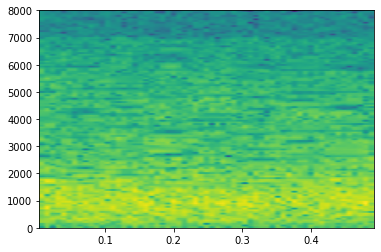

In [58]:
import random
from datetime import timedelta
from simpleaudio import play_buffer
from matplotlib.pyplot import specgram

idx = random.randint(0, len(X_v2))
# idx = 8904
rand_sample_aud_seg_begin_time = timedelta(seconds=sample_info_v2[idx]["file_seg_idx"]/audio_sample_rate)
print(f"Inspecting sample {idx}, size {len(X_v2[idx])}, {sample_info_v2[idx]}, {rand_sample_aud_seg_begin_time}")
print(idx_label_map)
print(y_v2[idx])
_ = specgram(X_v2[idx], Fs=audio_sample_rate)
_ = play_buffer(
    (X_v2[idx] * int16_iinfo.max).astype(np.int16).tobytes(),
    num_channels=1,
    bytes_per_sample=2,
    sample_rate=audio_sample_rate,
)
X_v2[idx].dtype

# Model V2 (Categorical)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               1536192   
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_2 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_3 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 579       
Total params: 1,647,939
Trainable params: 1,647,939
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
175/175 [==============================] - 2s 7ms/step - loss: 0.5141 - accuracy: 0.9987 - f1_score: 

<AxesSubplot:title={'center':'Model Acc'}>

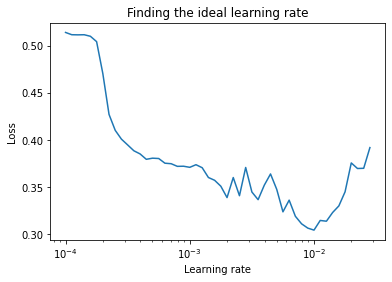

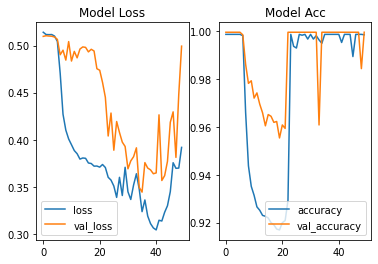

In [7]:
model_v2_test = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        # tf.keras.layers.Dense(len(label_idx_map), activation="sigmoid"),
        tf.keras.layers.Dense(len(label_idx_map), activation="sigmoid"),
    ]
)

model_v2_test.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # optimizer=tf.keras.optimizers.SGD(),
    # loss=tf.keras.losses.CategoricalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        "accuracy",
        # tf.keras.metrics.CategoricalAccuracy(),
        tfa.metrics.F1Score(num_classes=len(label_idx_map), threshold=0.5),
    ],
)

model_v2_test.summary()

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 20)
)

epochs = 40
history_v2_test = model_v2_test.fit(
    X_v2_train,
    y_v2_train,
    validation_data=(X_v2_test, y_v2_test),
    epochs=epochs,
    callbacks=[lr_scheduler],
)
# print(history_v2_test.history)

import matplotlib.pyplot as plt

lrs = 1e-4 * (10 ** (np.arange(epochs) / 20))
plt.semilogx(lrs, history_v2_test.history["loss"])  # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

# pd.DataFrame(history_v2_test.history).plot(title="Model History")
print(history_v2_test.history.keys())
fig, (ax) = plt.subplots(1,2)
losses = { k:v for k,v in history_v2_test.history.items() if "loss" in k}
pd.DataFrame(losses).plot(title="Model Loss", ax=ax[0])
accs = { k:v for k,v in history_v2_test.history.items() if "accuracy" in k or "score" in k}
pd.DataFrame(accs).plot(title="Model Acc", ax=ax[1])


<AxesSubplot:title={'center':'Validation F1 Score'}>

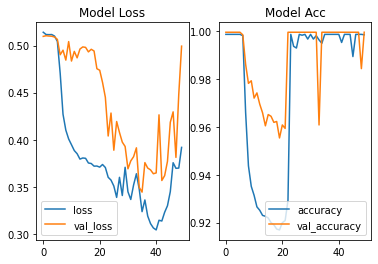

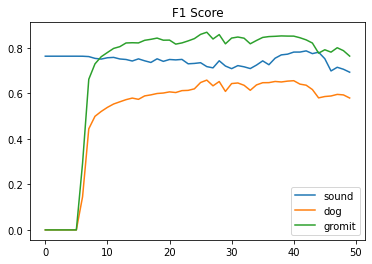

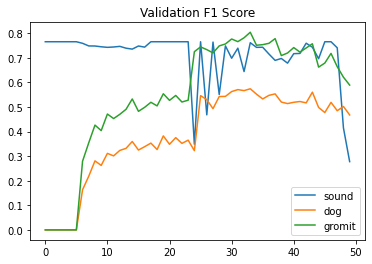

In [8]:
fig, (ax) = plt.subplots(1,2)
losses = { k:v for k,v in history_v2_test.history.items() if "loss" in k}
pd.DataFrame(losses).plot(title="Model Loss", ax=ax[0]) 
accs = { k:v for k,v in history_v2_test.history.items() if "accuracy" in k}
pd.DataFrame(accs).plot(title="Model Acc", ax=ax[1])
f1s = history_v2_test.history["f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="F1 Score")
f1s = history_v2_test.history["val_f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="Validation F1 Score")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1600)              12801600  
_________________________________________________________________
dense_17 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_18 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_19 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 4803      
Total params: 20,491,203
Trainable params: 20,491,203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [==============================] - 2s 11ms/step - loss: 0.5245 - accuracy: 0.9935 - f1_sc

<AxesSubplot:title={'center':'Validation F1 Score'}>

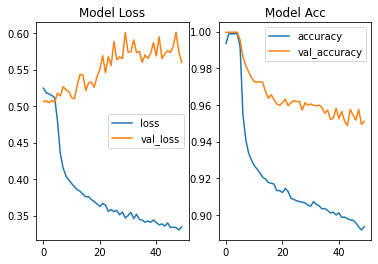

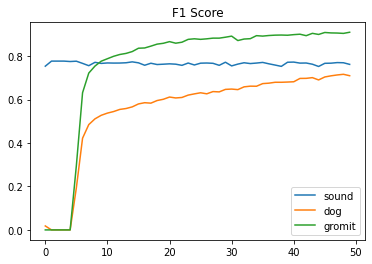

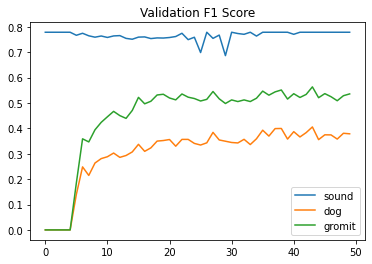

In [60]:
model_v2 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        # tf.keras.layers.Dense(len(label_idx_map), activation="softmax"),
        tf.keras.layers.Dense(len(label_idx_map), activation="sigmoid"),
    ]
)

model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        "accuracy",
        tfa.metrics.F1Score(num_classes=len(label_idx_map), threshold=0.5),
    ],
)

model_v2.summary()

epochs = 50
history_v2 = model_v2.fit(
    X_v2_train,
    y_v2_train,
    validation_data=(X_v2_test, y_v2_test),
    epochs=epochs,
)
# print(history_v2_test.history)

print(history_v2.history.keys())
fig, (ax) = plt.subplots(1, 2)
losses = {k: v for k, v in history_v2.history.items() if "loss" in k}
pd.DataFrame(losses).plot(title="Model Loss", ax=ax[0])
accs = {k: v for k, v in history_v2.history.items() if "accuracy" in k}
pd.DataFrame(accs).plot(title="Model Acc", ax=ax[1])
f1s = history_v2.history["f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="F1 Score")
f1s = history_v2.history["val_f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="Validation F1 Score")


(8977, 8000). Testing sample 2575
[[0.53851223 0.09598146 0.01968419]] [0. 0. 0.]
['sound', 'dog', 'gromit']
(8977, 3)
[[0.535401   0.09093112 0.0184177 ]
 [0.5337619  0.0883068  0.01776661]
 [0.51814806 0.06422338 0.01201901]
 ...
 [0.5146675  0.05879109 0.01077745]
 [0.52080387 0.06822035 0.01294301]
 [0.5340897  0.08883837 0.01789849]] [[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[[   0 3267]
  [   0 5710]]

 [[7052   48]
  [ 964  913]]

 [[7864   64]
  [ 294  755]]]


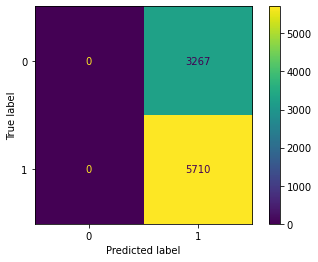

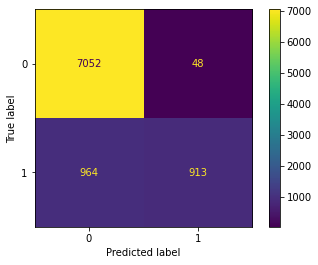

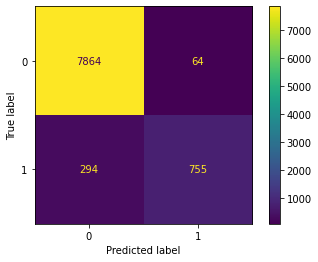

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

idx = random.randint(0, len(X_v2))
print(f"{X_v2.shape}. Testing sample {idx}")
result = model_v2.predict(np.asarray([X_v2[idx]]))
print(result, y_v2[idx])
print(idx_label_map)
y_v2_pred = model_v2.predict(X_v2)
print(y_v2_pred.shape)
# y_v2_pred_rnd = np.round(y_v2_pred)
y_v2_pred_rnd = np.where(y_v2_pred > 0.3, 1, 0)
print(y_v2_pred, y_v2_pred_rnd)
cm = multilabel_confusion_matrix(y_v2, y_v2_pred_rnd, )
print(cm)

for sub_cm in cm:
    disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm)
    disp.plot()

# CNN Model


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 7998, 10)          40        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7996, 10)          310       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3998, 10)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3996, 10)          310       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3994, 10)          310       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1997, 10)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1995, 10)         

<AxesSubplot:title={'center':'Validation F1 Score'}>

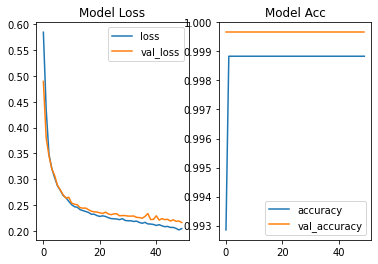

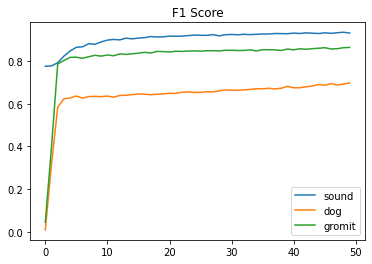

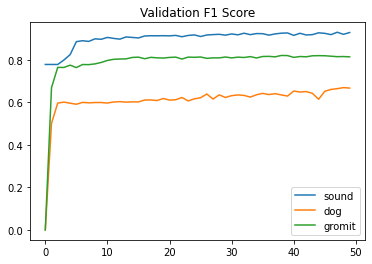

In [62]:
X_v3_train = np.expand_dims(X_v2_train, axis=2)
X_v3_test = np.expand_dims(X_v2_test, axis=2)
# print(X_v2_train.shape)
# print(X_v3_train.shape)
y_v3_train = y_v2_train
y_v3_test = y_v2_test

model_v3_test = tf.keras.Sequential(
    [
        # tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Conv1D(
            filters=10, kernel_size=3, activation="relu",
            input_shape=(int(model_sample_length), 1),
        ),
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.MaxPool1D(),
        
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.MaxPool1D(),

        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.MaxPool1D(),

        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.MaxPool1D(),

        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu",),
        tf.keras.layers.MaxPool1D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(len(label_idx_map), activation="sigmoid"),
    ]
)

model_v3_test.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        "accuracy",
        tfa.metrics.F1Score(num_classes=len(idx_label_map), threshold=0.5),
    ],
)

model_v3_test.summary()

epochs = 50
history_v3_test = model_v3_test.fit(
    X_v3_train,
    y_v3_train,
    validation_data=(X_v3_test, y_v3_test),
    epochs=epochs,
)
# print(history_v3_test.history)


print(history_v3_test.history.keys())
fig, (ax) = plt.subplots(1,2)
losses = { k:v for k,v in history_v3_test.history.items() if "loss" in k}
pd.DataFrame(losses).plot(title="Model Loss", ax=ax[0]) 
accs = { k:v for k,v in history_v3_test.history.items() if "accuracy" in k}
pd.DataFrame(accs).plot(title="Model Acc", ax=ax[1])
f1s = history_v3_test.history["f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="F1 Score")
f1s = history_v3_test.history["val_f1_score"]
pd.DataFrame(f1s, columns=idx_label_map).plot(title="Validation F1 Score")

(2963, 8000, 1). Testing sample 197
(1, 8000, 1)
[[0.17133114 0.10196874 0.0153194 ]] [0. 0. 0.]
['sound', 'dog', 'gromit']
(2963, 8000, 1)
(8977, 3)
[[[1034   41]
  [ 216 1672]]

 [[2332   32]
  [ 283  316]]

 [[2615   14]
  [  95  239]]]


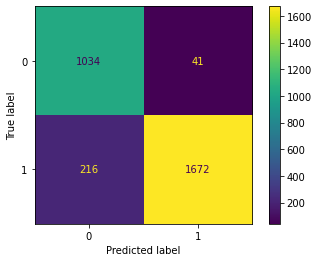

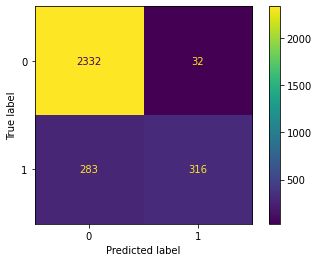

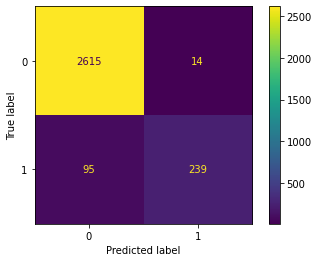

In [74]:
idx = random.randint(0, len(X_v3_test))
print(f"{X_v3_test.shape}. Testing sample {idx}")
model_v3_test_input = np.expand_dims(np.asarray([X_v2[idx]]), axis=2)
print(model_v3_test_input.shape)
result = model_v3_test.predict(model_v3_test_input)
print(result, y_v2[idx])
print(idx_label_map)

# model_v3_test_input = np.expand_dims(X_v2, axis=2)
model_v3_test_input = X_v3_test
print(model_v3_test_input.shape)
y_v3_pred = model_v3_test.predict(model_v3_test_input)
print(y_v2_pred.shape)
y_v3_pred_rnd = np.where(y_v3_pred > 0.5, 1, 0)
# print(y_v3_pred, y_v3_pred_rnd)
# cm = multilabel_confusion_matrix(y_v2, y_v3_pred_rnd)
cm = multilabel_confusion_matrix(y_v3_test, y_v3_pred_rnd)
print(cm)

for sub_cm in cm:
    disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm)
    disp.plot()